# PMEmo Dataset - Feed Forward Neural Network
## Essentia Best Valence Mean Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_pmemo_path('processed/annotations/pmemo_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,1,0.150,-0.200
1,4,-0.425,-0.475
2,5,-0.600,-0.700
3,6,-0.300,0.025
4,7,0.450,0.400
...,...,...,...
762,993,0.525,0.725
763,996,0.125,0.750
764,997,0.325,0.425
765,999,0.550,0.750


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_valence_features_mean = pd.read_csv(get_pmemo_path('processed/features/normalised_essentia_best_valence_features_mean.csv'))

# drop Unnamed:0 column
df_essentia_best_valence_features_mean = df_essentia_best_valence_features_mean[df_essentia_best_valence_features_mean.columns[1:]]

df_essentia_best_valence_features_mean

,song_id,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,lowlevel.zerocrossingrate.mean,rhythm.beats_loudness.mean,rhythm.onset_rate,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,1,0.064362,0.214289,0.125964,0.416985,0.086404,0.810704,0.267193,0.482615,0.533418,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.089160,0.000000,0.223899,0.098657,0.288181
1,4,0.345452,0.539877,0.949078,0.050339,0.462009,0.795216,0.304507,0.461919,0.163914,...,0.016972,0.077021,0.402838,0.000000,0.030457,0.117746,0.000000,0.107674,0.000000,0.155779
2,5,0.566046,0.636537,0.525953,0.171160,0.308063,0.844622,0.464434,0.609828,0.714130,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.008505,0.007329,0.000000,0.000000,0.000000
3,6,0.168166,0.426521,0.278434,0.265749,0.139343,0.765399,0.362823,0.392684,0.381464,...,0.000000,0.063161,0.000000,0.000000,0.000000,0.000000,0.000000,0.051213,0.000000,0.000000
4,7,0.050890,0.193447,0.201743,0.447316,0.231818,0.578654,0.445732,0.675341,0.746939,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.165104,0.096976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,993,0.058467,0.186511,0.184759,0.536035,0.124013,0.551773,0.555560,0.580548,0.612516,...,0.000000,0.000000,0.000000,0.031499,0.000000,0.000000,0.000000,0.013240,0.156009,0.863862
763,996,0.121857,0.234562,0.179638,0.633059,0.073642,0.674339,0.552154,0.660622,0.638703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044460,0.016906
764,997,0.046206,0.200557,0.195031,0.620730,0.097882,0.520823,0.144097,0.571115,0.554702,...,0.008208,0.025688,0.000000,0.053602,0.000000,0.027702,0.000000,0.149709,0.035320,0.149458
765,999,0.063658,0.238118,0.238011,0.658759,0.140357,0.433236,0.136955,0.490124,0.476657,...,0.000000,0.000000,0.000000,0.000000,0.005471,0.000000,0.051231,0.000000,0.112450,0.019859


In [4]:
df_essentia_best_valence_features_mean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 743 columns):
 #    Column                                   Dtype  
---   ------                                   -----  
 0    song_id                                  int64  
 1    lowlevel.melbands_kurtosis.mean          float64
 2    lowlevel.melbands_skewness.mean          float64
 3    lowlevel.spectral_energy.mean            float64
 4    lowlevel.zerocrossingrate.mean           float64
 5    rhythm.beats_loudness.mean               float64
 6    rhythm.onset_rate                        float64
 7    tonal.chords_strength.mean               float64
 8    tonal.hpcp_entropy.mean                  float64
 9    tonal.key_edma.strength                  float64
 10   tonal.key_temperley.strength             float64
 11   lowlevel.gfcc.cov_0                      float64
 12   lowlevel.gfcc.cov_1                      float64
 13   lowlevel.gfcc.cov_2                      float64
 14   lowlevel

Join both the featureset and annotation set together

In [5]:
df_essentia_best_valence_features_mean_whole = pd.merge(df_essentia_best_valence_features_mean, df_annotations, how='inner', on='song_id')
df_essentia_best_valence_features_mean_whole = df_essentia_best_valence_features_mean_whole.drop('song_id', axis=1)
df_essentia_best_valence_features_mean_whole

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,lowlevel.zerocrossingrate.mean,rhythm.beats_loudness.mean,rhythm.onset_rate,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,...,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23,valence_mean_mapped,arousal_mean_mapped
0,0.064362,0.214289,0.125964,0.416985,0.086404,0.810704,0.267193,0.482615,0.533418,0.570785,...,0.000000,0.000000,0.000000,0.089160,0.000000,0.223899,0.098657,0.288181,0.150,-0.200
1,0.345452,0.539877,0.949078,0.050339,0.462009,0.795216,0.304507,0.461919,0.163914,0.158169,...,0.402838,0.000000,0.030457,0.117746,0.000000,0.107674,0.000000,0.155779,-0.425,-0.475
2,0.566046,0.636537,0.525953,0.171160,0.308063,0.844622,0.464434,0.609828,0.714130,0.649047,...,0.000000,0.000000,0.000000,0.008505,0.007329,0.000000,0.000000,0.000000,-0.600,-0.700
3,0.168166,0.426521,0.278434,0.265749,0.139343,0.765399,0.362823,0.392684,0.381464,0.311019,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.051213,0.000000,0.000000,-0.300,0.025
4,0.050890,0.193447,0.201743,0.447316,0.231818,0.578654,0.445732,0.675341,0.746939,0.781565,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.165104,0.096976,0.450,0.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,0.058467,0.186511,0.184759,0.536035,0.124013,0.551773,0.555560,0.580548,0.612516,0.656733,...,0.000000,0.031499,0.000000,0.000000,0.000000,0.013240,0.156009,0.863862,0.525,0.725
763,0.121857,0.234562,0.179638,0.633059,0.073642,0.674339,0.552154,0.660622,0.638703,0.659746,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044460,0.016906,0.125,0.750
764,0.046206,0.200557,0.195031,0.620730,0.097882,0.520823,0.144097,0.571115,0.554702,0.580168,...,0.000000,0.053602,0.000000,0.027702,0.000000,0.149709,0.035320,0.149458,0.325,0.425
765,0.063658,0.238118,0.238011,0.658759,0.140357,0.433236,0.136955,0.490124,0.476657,0.512086,...,0.000000,0.000000,0.005471,0.000000,0.051231,0.000000,0.112450,0.019859,0.550,0.750


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_valence_features_mean.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,lowlevel.zerocrossingrate.mean,rhythm.beats_loudness.mean,rhythm.onset_rate,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,0.064362,0.214289,0.125964,0.416985,0.086404,0.810704,0.267193,0.482615,0.533418,0.570785,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.089160,0.000000,0.223899,0.098657,0.288181
1,0.345452,0.539877,0.949078,0.050339,0.462009,0.795216,0.304507,0.461919,0.163914,0.158169,...,0.016972,0.077021,0.402838,0.000000,0.030457,0.117746,0.000000,0.107674,0.000000,0.155779
2,0.566046,0.636537,0.525953,0.171160,0.308063,0.844622,0.464434,0.609828,0.714130,0.649047,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.008505,0.007329,0.000000,0.000000,0.000000
3,0.168166,0.426521,0.278434,0.265749,0.139343,0.765399,0.362823,0.392684,0.381464,0.311019,...,0.000000,0.063161,0.000000,0.000000,0.000000,0.000000,0.000000,0.051213,0.000000,0.000000
4,0.050890,0.193447,0.201743,0.447316,0.231818,0.578654,0.445732,0.675341,0.746939,0.781565,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.165104,0.096976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,0.058467,0.186511,0.184759,0.536035,0.124013,0.551773,0.555560,0.580548,0.612516,0.656733,...,0.000000,0.000000,0.000000,0.031499,0.000000,0.000000,0.000000,0.013240,0.156009,0.863862
763,0.121857,0.234562,0.179638,0.633059,0.073642,0.674339,0.552154,0.660622,0.638703,0.659746,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044460,0.016906
764,0.046206,0.200557,0.195031,0.620730,0.097882,0.520823,0.144097,0.571115,0.554702,0.580168,...,0.008208,0.025688,0.000000,0.053602,0.000000,0.027702,0.000000,0.149709,0.035320,0.149458
765,0.063658,0.238118,0.238011,0.658759,0.140357,0.433236,0.136955,0.490124,0.476657,0.512086,...,0.000000,0.000000,0.000000,0.000000,0.005471,0.000000,0.051231,0.000000,0.112450,0.019859


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,0.150,-0.200
1,-0.425,-0.475
2,-0.600,-0.700
3,-0.300,0.025
4,0.450,0.400
...,...,...
762,0.525,0.725
763,0.125,0.750
764,0.325,0.425
765,0.550,0.750


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [12]:
num_epochs = 300

Set a random seed to ensure consistent initial weights of the neural network

In [13]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [15]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([613, 742])


Training loop

In [16]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [17]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.650410030407706
Epoch 2, Loss: 0.6459746411279922
Epoch 3, Loss: 0.6416126871523545
Epoch 4, Loss: 0.6375532707695886
Epoch 5, Loss: 0.6336942581251322
Epoch 6, Loss: 0.630001914422593
Epoch 7, Loss: 0.6265504441088404
Epoch 8, Loss: 0.6231732613977309
Epoch 9, Loss: 0.6198640321644744
Epoch 10, Loss: 0.6166051217460674
Epoch 11, Loss: 0.6133670868301936
Epoch 12, Loss: 0.610256535571278
Epoch 13, Loss: 0.607290272086774
Epoch 14, Loss: 0.6043625355158097
Epoch 15, Loss: 0.6015415931140213
Epoch 16, Loss: 0.5987990927828234
Epoch 17, Loss: 0.59612246902898
Epoch 18, Loss: 0.5937126549470603
Epoch 19, Loss: 0.5921507428922907
Epoch 20, Loss: 0.5922823133030879
Epoch 21, Loss: 0.5936999550860341
Epoch 22, Loss: 0.5942395852042492
Epoch 23, Loss: 0.5937741927187319
Epoch 24, Loss: 0.5928925546938177
Epoch 25, Loss: 0.5920854123173221
Epoch 26, Loss: 0.5915439178401749
Epoch 27, Loss: 0.591233945713277
Epoch 28, Loss: 0.5910767810391497
Epoch 29, Loss: 0.5910590832169714
E

Epoch 43, Loss: 0.5910160465579348
Epoch 44, Loss: 0.5910078775587659
Epoch 45, Loss: 0.5910038434434545
Epoch 46, Loss: 0.5910011960403165
Epoch 47, Loss: 0.5909968845298225
Epoch 48, Loss: 0.5909877571348259
Epoch 49, Loss: 0.5909722251110124
Epoch 50, Loss: 0.5909492288975793
Epoch 51, Loss: 0.5909180867654118
Epoch 52, Loss: 0.590880159231653
Epoch 53, Loss: 0.5908393289327294
Epoch 54, Loss: 0.590796805930882
Epoch 55, Loss: 0.5907521862759616
Epoch 56, Loss: 0.590702190098239
Epoch 57, Loss: 0.5906453275462308
Epoch 58, Loss: 0.5905771811367462
Epoch 59, Loss: 0.5904953244062136
Epoch 60, Loss: 0.5903964453199938
Epoch 61, Loss: 0.5902762942825325
Epoch 62, Loss: 0.5901333432729927
Epoch 63, Loss: 0.5899618422162785
Epoch 64, Loss: 0.5897478442506414
Epoch 65, Loss: 0.5894854638472858
Epoch 66, Loss: 0.5891686422305009
Epoch 67, Loss: 0.58877494431154
Epoch 68, Loss: 0.588286079903643
Epoch 69, Loss: 0.5876927597279505
Epoch 70, Loss: 0.5869446300601179
Epoch 71, Loss: 0.58597541

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [18]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([154, 742])


Generating scores

In [19]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score: {r2_score}')
  return test_pred, rmse, r2_score

In [20]:
test_pred, rmse, r2_score = test_model(model)

Test RMSE: 0.23443511729541908
Valence RMSE: 0.24262136432704848
Arousal RMSE: 0.22595247733697327
Test R^2 score: tensor([0.3710, 0.6235], dtype=torch.float64)


In [21]:
torch.save(model.state_dict(), '../../models/pmemo_feedforward_nn_essentia_best_valence_mean_normalised.pt')

True values (test set)

In [22]:
target_test_labels

tensor([[-0.5750,  0.3500],
        [ 0.1250, -0.0250],
        [ 0.2000,  0.4750],
        [ 0.3500,  0.3500],
        [ 0.3000,  0.4500],
        [ 0.3500,  0.0250],
        [ 0.3250, -0.0250],
        [ 0.3750,  0.3500],
        [ 0.1500,  0.1000],
        [ 0.2750,  0.6500],
        [ 0.5000,  0.5250],
        [ 0.0500, -0.3500],
        [ 0.0500,  0.2250],
        [-0.3250, -0.4500],
        [-0.1000,  0.4500],
        [ 0.1250, -0.4000],
        [ 0.3750,  0.5500],
        [ 0.2000, -0.2250],
        [-0.4500, -0.3000],
        [ 0.0500,  0.0750],
        [ 0.2750,  0.4250],
        [-0.0250,  0.4000],
        [ 0.6500,  0.6750],
        [-0.1750, -0.3250],
        [-0.6500,  0.6500],
        [ 0.0250,  0.3000],
        [-0.0500,  0.6750],
        [-0.7250, -0.4500],
        [ 0.0000, -0.2750],
        [ 0.2750,  0.4500],
        [ 0.0000, -0.2000],
        [ 0.3250,  0.2250],
        [-0.3750, -0.1250],
        [-0.1000,  0.2250],
        [ 0.4000,  0.2250],
        [ 0.3500,  0

Predicted values

In [23]:
test_pred

tensor([[ 1.5577e-01,  2.1835e-01],
        [ 1.3380e-01,  1.6136e-01],
        [ 4.5622e-01,  5.7208e-01],
        [ 5.8336e-02,  2.1370e-02],
        [ 4.4037e-01,  5.3074e-01],
        [-2.0288e-01, -1.7777e-01],
        [-7.8618e-02, -4.4369e-02],
        [ 4.4832e-01,  5.5150e-01],
        [-3.3905e-01, -3.5932e-01],
        [ 4.6401e-01,  5.9250e-01],
        [ 4.5448e-01,  5.6756e-01],
        [-2.8570e-01, -5.0269e-01],
        [-2.9286e-01, -1.9611e-01],
        [-2.7245e-01, -2.3350e-01],
        [ 2.5928e-01,  3.3261e-01],
        [ 1.1035e-01,  9.4527e-02],
        [ 2.3434e-01,  2.6040e-01],
        [ 2.9592e-01,  3.3159e-01],
        [-2.9470e-01, -2.8463e-01],
        [ 3.0237e-01,  3.3258e-01],
        [ 1.4560e-01,  1.3529e-01],
        [-7.4763e-02, -3.2510e-02],
        [ 2.7019e-01,  3.1831e-01],
        [-3.2383e-01, -5.1126e-01],
        [-1.5032e-01,  8.7258e-03],
        [ 9.5408e-02,  1.6199e-01],
        [ 2.9313e-01,  3.3277e-01],
        [-3.1539e-01, -5.162

In [24]:
pred_valence = test_pred[:, 0]
pred_arousal = test_pred[1]
real_valence = target_test_labels[0]
real_arousal = target_test_labels[1]


metric = R2Score(multioutput='raw_values')
metric.update(test_pred, target_test_labels)
print(metric.compute())

tensor([0.3710, 0.6235], dtype=torch.float64)


## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [25]:
num_epochs_list = [i for i in range(1, 301)]
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [26]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, r2_score = test_model(model)
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.650410030407706
Training completed.
Training completed.
Testing model...
Test RMSE: 0.4071492850037976
Valence RMSE: 0.3931229731524217
Arousal RMSE: 0.4207082225699988
Test R^2 score: tensor([-0.6515, -0.3053], dtype=torch.float64)
Num of epochs: 2
Epoch 1, Loss: 0.650410030407706
Epoch 2, Loss: 0.6459746411279922
Training completed.
Training completed.
Testing model...
Test RMSE: 0.40142422932138666
Valence RMSE: 0.38622772545872075
Arousal RMSE: 0.41606606189344675
Test R^2 score: tensor([-0.5940, -0.2767], dtype=torch.float64)
Num of epochs: 3
Epoch 1, Loss: 0.650410030407706
Epoch 2, Loss: 0.6459746411279922
Epoch 3, Loss: 0.6416126871523545
Training completed.
Training completed.
Testing model...
Test RMSE: 0.39613138557940497
Valence RMSE: 0.37977878655769176
Arousal RMSE: 0.4118351885923368
Test R^2 score: tensor([-0.5413, -0.2509], dtype=torch.float64)
Num of epochs: 4
Epoch 1, Loss: 0.650410030407706
Epoch 2, Loss: 0.6459746411279922
Epoch 3,

### Plot the graph to visualise the relationship between epochs and r^2 score

Import relevant libraries

In [27]:
import matplotlib.pyplot as plt

In [28]:
r2_scores_list

[tensor([-0.6515, -0.3053], dtype=torch.float64),
 tensor([-0.5940, -0.2767], dtype=torch.float64),
 tensor([-0.5413, -0.2509], dtype=torch.float64),
 tensor([-0.4915, -0.2271], dtype=torch.float64),
 tensor([-0.4439, -0.2055], dtype=torch.float64),
 tensor([-0.4004, -0.1855], dtype=torch.float64),
 tensor([-0.3595, -0.1655], dtype=torch.float64),
 tensor([-0.3208, -0.1456], dtype=torch.float64),
 tensor([-0.2833, -0.1264], dtype=torch.float64),
 tensor([-0.2467, -0.1075], dtype=torch.float64),
 tensor([-0.2121, -0.0897], dtype=torch.float64),
 tensor([-0.1798, -0.0727], dtype=torch.float64),
 tensor([-0.1493, -0.0555], dtype=torch.float64),
 tensor([-0.1197, -0.0395], dtype=torch.float64),
 tensor([-0.0897, -0.0255], dtype=torch.float64),
 tensor([-0.0596, -0.0132], dtype=torch.float64),
 tensor([-0.0311, -0.0039], dtype=torch.float64),
 tensor([-0.0105, -0.0006], dtype=torch.float64),
 tensor([-0.0088, -0.0061], dtype=torch.float64),
 tensor([-0.0256, -0.0148], dtype=torch.float64),


Plot the line graph

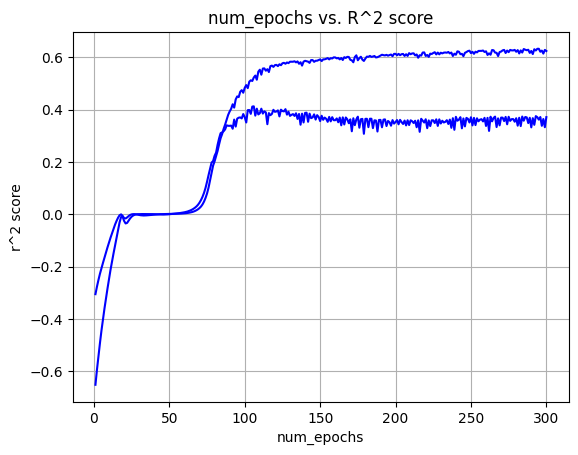

In [29]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. R^2 score')
plt.xlabel('num_epochs')
plt.ylabel('r^2 score') 
plt.grid(True)
plt.show() 

In [30]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

RuntimeError: Boolean value of Tensor with more than one value is ambiguous